In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import os

import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [7]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [413]:
df=pd.read_csv('Wine.csv')

> Referneces
>
>https://ssungkang.tistory.com/entry/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5-PCA-2-python-%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%9C-PCA-%EC%8B%A4%EC%8A%B5?category=324327
>
>https://365datascience.com/pca-k-means/

# Quest. 와인 성질으로 소비자 분류하기

데이터의 Customer_Segment를 모른다고 가정할 때, PCA 와 Clustering 을 이용해 소비자를 분류해봅시다. 

## 데이터셋 설명
>* Alcohol : 도수
>* Color_Intensity : 색의 강도
>* Hue : 색상
>* Customer_Segment : 소비자 분류 (1,2,3)

따로 설명을 적지 않은 변수는 화학물질 입니다.

출처: https://www.kaggle.com/sadeghjalalian/wine-customer-segmentation

## 1) PCA를 위한 데이터 전처리를 해주세요

In [414]:
df=df.set_index('Customer_Segment').reset_index()
df.head()

,Customer_Segment,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [415]:
df.isnull().sum()

Customer_Segment        0
Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

In [416]:
#'Customer_Segment'는 categorical 변수이므로 str으로 바꿔준다
#df['Customer_Segment']=df['Customer_Segment'].astype(str)

In [417]:
# label 과 target 값으로 나눠준다
X = df.drop('Customer_Segment',axis=1).values
y = df['Customer_Segment'].values

In [418]:
#StandardScaler 를 통해 데이터를 단위 분산으로 조정
#평균을 0, 분산을 1 
X = StandardScaler().fit_transform(X)

In [419]:
X[:2]

array([[ 1.51861254, -0.5622498 ,  0.23205254, -1.16959318,  1.91390522,
         0.80899739,  1.03481896, -0.65956311,  1.22488398,  0.25171685,
         0.36217728,  1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, -2.49084714,  0.01814502,
         0.56864766,  0.73362894, -0.82071924, -0.54472099, -0.29332133,
         0.40605066,  1.1134493 ,  0.96524152]])

## 몇개의 주성분이 적당할까요?

In [420]:
#먼저, n_component를 설정하지 않고 pca에 fit을 시겨본다
pca = PCA()
pca.fit(X)

# 몇개의 주성분이 적당할까? 
print('explaine variance ratio : ', pca.explained_variance_ratio_)
# PCA().fit(x_scaled).explained_variance_ratio_ 와 같음
print('cumulative variance : ', np.cumsum(pca.explained_variance_ratio_)) 


explaine variance ratio :  [0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019 0.01736836 0.01298233
 0.00795215]
cumulative variance :  [0.36198848 0.55406338 0.66529969 0.73598999 0.80162293 0.85098116
 0.89336795 0.92017544 0.94239698 0.96169717 0.97906553 0.99204785
 1.        ]


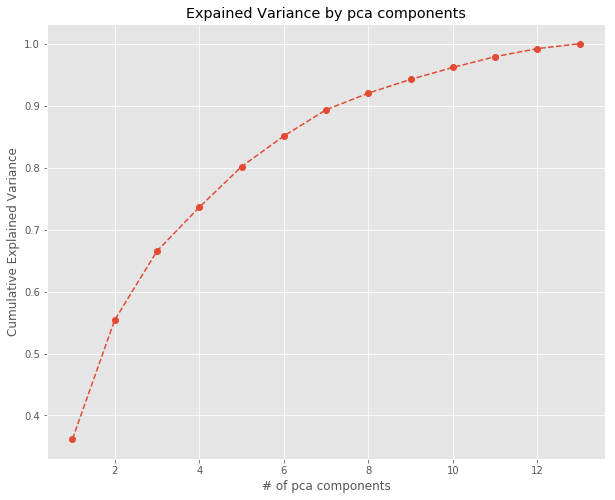

In [421]:
#시각화로 한눈에 보기 편하게 해준다
plt.figure(figsize=(10,8))
plt.plot(range(1,14),pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Expained Variance by pca components')
plt.xlabel('# of pca components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

cumulative variance plot 를 통해, 주성분 5개를 통해 80%의 Explained Variance를 보존하는 것이 적절할 것으로 예상한다

## PCA 를 진행해봅시다. 
### (1) 2개의 pca_component로 나눠본다

In [422]:
def pca_func(X,n_components):
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component '+str(i) for i in range(1,n_components+1)])
    #기존에 있던 label과 합쳐준다
    final_df = pd.concat([principalDf, df[['Customer_Segment']]], axis=1)
    #explained_variance_ratio_도 리턴해준다
    cum_var=np.cumsum(pca.explained_variance_ratio_)
    return final_df, cum_var, principalComponents


In [423]:
final_df, cum_var,_=pca_func(X,2)
final_df.head()

,principal component 1,principal component 2,Customer_Segment
0,3.316751,-1.443463,1
1,2.209465,0.333393,1
2,2.516740,-1.031151,1
3,3.757066,-2.756372,1
4,1.008908,-0.869831,1


In [424]:
print('cumulative variance : ', cum_var) 

cumulative variance :  [0.36198848 0.55406338]


Explained Variance의 55%까지 반영한 결과이다

In [425]:
labels = [i for i in df['Customer_Segment'].unique()]
labels

[1, 2, 3]

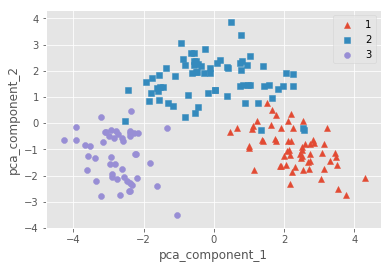

In [426]:
# 4차원 그래프를 2차원 그래프로 잘 표현하는지 확인해보자

# Customer_Segment label -> 1를 세모, 2 네모, 3 동그라미로 표시
markers=['^', 's', 'o']

# pca_component_1 을 x축, pc_component_2를 y축으로 scatter plot 수행. 
for i, marker in enumerate(markers):
    x_axis_data = final_df[final_df['Customer_Segment']==i+1]['principal component 1']
    y_axis_data = final_df[final_df['Customer_Segment']==i+1]['principal component 2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=labels[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

2개의 주성분으로도 구분이 잘되지만, Explained Variance를 50%밖에 반영시키지 못했기 때문에, 앞서 제시한 5개의 주성분으로 나눠본다

### (2) 5개의 pca_component로 나눠본다

In [427]:
final_df2, cum_var2, score_pca =pca_func(X,5)
final_df2.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Customer_Segment
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,1
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,1
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,1
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,1
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,1


In [428]:
print('cumulative variance : ', cum_var2)

cumulative variance :  [0.36198848 0.55406338 0.66529969 0.73598999 0.80162293]


Explained Variance의 80%만 반영한 결과이다

## 주성분의 loadings를 찾아봅시다.
세션에서는 다루지 않았던 내용입니다. 구글링해서 도전해보세요!
>* loadings: coefficients of the linear combinations

In [436]:
#위에서 함수안에 pca 인스턴스로 불러오고, PCA().components_는 리턴값에 안넣어서 새롭게 fir_transform해서 로딩을 구했습니다
from sklearn import decomposition
pca__ = decomposition.PCA(n_components=5)
pca__X = pca__.fit_transform(X)

In [437]:
pca__.components_.T.shape

(13, 5)

In [447]:
loadings = pd.DataFrame(pca__.components_.T, 
                        columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index=df.columns[1:])
loadings
#각 주성분이 original features에게 얼만큼 영향을 받았는지
#PC1: Flavanoids, PC2: Color_Intensity, PC3: Ash, PC4: Malic_Acid, PC5: Magnesium 에 가장 많은 영향을 받았다

,PC1,PC2,PC3,PC4,PC5
Alcohol,0.144329,-0.483652,-0.207383,-0.017856,-0.265664
Malic_Acid,-0.245188,-0.224931,0.089013,0.536890,0.035214
Ash,-0.002051,-0.316069,0.626224,-0.214176,-0.143025
Ash_Alcanity,-0.239320,0.010591,0.612080,0.060859,0.066103
Magnesium,0.141992,-0.299634,0.130757,-0.351797,0.727049
Total_Phenols,0.394661,-0.065040,0.146179,0.198068,-0.149318
Flavanoids,0.422934,0.003360,0.150682,0.152295,-0.109026
Nonflavanoid_Phenols,-0.298533,-0.028779,0.170368,-0.203301,-0.500703
Proanthocyanins,0.313429,-0.039302,0.149454,0.399057,0.136860
Color_Intensity,-0.088617,-0.529996,-0.137306,0.065926,-0.076437


## PCA 한 결과로 K-means clusterig 해봅시다
우리의 목적은 와인의 성질으로 주성분을 찾고 clustering 해서,   
소비자를 분류하는 것입니다.  
Customer_Segment 와 비교를 위해 k=3 으로 분류해봅시다. 

In [233]:
#pca 한 결과를 k-means에 fit해준다
#먼저 클러스터개수를 20개로 설정하여 plotting
#이후, Customer_Segment 와 비교를 위해 k=3인 점의 inertia를 살펴본다

lis=[]
for i in range(1,21):
    kmeans_pca=KMeans(n_clusters=i, init='k-means++', random_state=1237)
    kmeans_pca.fit(score_pca)
    lis.append(kmeans_pca.inertia_)

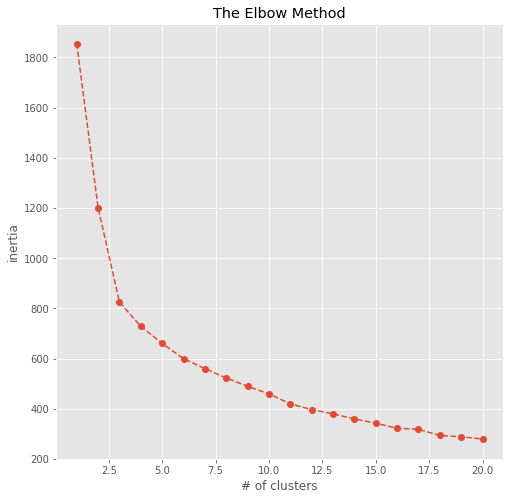

In [237]:
#Visualizing the ELBOW method to get the optimal value of K 
plt.figure(figsize=(8, 8))
plt.plot(range(1,21), lis, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('# of clusters')
plt.ylabel('inertia')
plt.show()

plot을 확인해보니, 클러스터 개수가 3~5개일 때, 그래프가 꺾이기 시작하는 것을 볼 수 있다

In [238]:
#kmeans실행
##Finally we got that k=3

#Model Build
kmeans_pca = KMeans(n_clusters= 3, init='k-means++', random_state=1237)
y_kmeans= kmeans_pca.fit_predict(score_pca)

#주의: unsupervised learning에서는 "fit_predict()"를 사용, 
#supervised learning에서는 "fit_transform()"을 사용.

In [ ]:
#pca한 결과의 데이터프레임과 원래 df를 merge
df_pca_km=pd.merge(daf,final_df2, on='Customer_Segment')
#마지막 칼럼에 pca_k-means 로 클러스터링한 predict 라벨을 붙여준다
df_pca_km['PCA_Kmeans_label']=y_kmeans

## clustering 결과를 비교해봅시다.
원래 데이터의 Customer_Segment와 비교해봅시다.      
(Customer_Segment 가 정답이라는 말은 아니에요..ㅎ)

In [206]:
final_df2.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Customer_Segment
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,1
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,1
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,1
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,1
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,1


In [253]:
#pca한 결과의 데이터프레임과 원래 df를 concat
#Customer_Segment 칼럼이 두개 다 있어서 df에서 드랍해줬음
df_pca_km=pd.concat([df.drop('Customer_Segment',axis=1),final_df2], axis=1)

#마지막 칼럼에 pca_k-means 로 클러스터링한 라벨을 붙여준다
#클러스터링된 결과는 0부터 시작하니까 실제 customer_segment와 비교하기 어려울 것같아서 (customer_segment는 1부터 시작하므로)
#y_kmeans+1을 해준다
df_pca_km['PCA_Kmeans_label']=y_kmeans+1

In [254]:
df_pca_km.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,Customer_Segment,PCA_Kmeans_label
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,3.316751,-1.443463,-0.165739,-0.215631,0.693043,1,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2.209465,0.333393,-2.026457,-0.291358,-0.257655,1,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2.516740,-1.031151,0.982819,0.724902,-0.251033,1,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,3.757066,-2.756372,-0.176192,0.567983,-0.311842,1,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1.008908,-0.869831,2.026688,-0.409766,0.298458,1,1


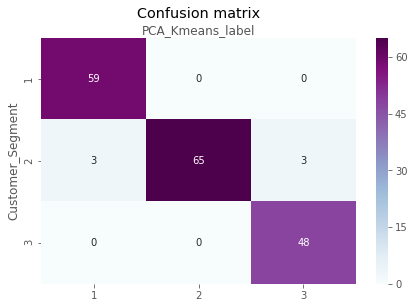

In [272]:
cm = confusion_matrix(df_pca_km['Customer_Segment'],df_pca_km['PCA_Kmeans_label'])
class_names=[1,2,3] # name  of classes
fig, ax = plt.subplots()

# create heatmap
sns.heatmap(pd.DataFrame(cm, index=class_names,columns=class_names), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Customer_Segment')
plt.xlabel('PCA_Kmeans_label')
plt.show()


> confusion matrix로 비교해보니 178개 중 6개를 제외하고 일치하는 결과를 보인다
>
> * 불일치 값들:
> * (pca_kmeans,customer_seg)=(1,2) ->3개
> * (pca_kmeans,customer_seg)=(3,2) ->3개


# *K-means 알고리즘의 한계
K-means 알고리즘은 "평균"을 계산하는 것이기 떄문에 outlier 에 취약합니다.  
Outlier 가 있을 때 주로 사용하는 알고리즘을 찾아보세요.   
힌트는 "평균" 입니다.


### DBSCAN
> 밀도있게 연결되어있는 데이터 집합을 동일한 클러스터로 판단
* 군집의 형태에 구애받지 않으며 군집의 갯수를 사용자가 지정할 필요가 없다.
* 초기 데이터로부터 근접한 데이터를 찾아나가는 방법으로 군집을 확장한다.
* 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류
* eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류
>
> -> 아웃라이어, 노이즈가 있는 데이터 식별에 강하다

https://datascienceschool.net/view-notebook/e335aec955e844a981b41e4e11f79174/

## DBSCAN 모델링 후 clustering 결과를 비교해보자

In [305]:
from sklearn.cluster import DBSCAN

In [352]:
def tuning(eps, min_samples):
    #eps, min_samples의 경우, 너무 작은 값을 설정하면 모든 값이 (노이즈를 뜻하는) -1로 나와서,
    #함수로 몇가지 경우의 수를 조사해보았다
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    #pca한 결과를 dbscan에 넣는다
    y_dbscan = dbscan.fit_predict(score_pca)
    clustered_lbs=np.unique(y_dbscan)
    if len(clustered_lbs)==3: 
        print('eps:',eps,'min_samples:',min_samples,'클러스터 라벨:',clustered_lbs)

In [364]:
eps_space=np.arange(0.1,3,0.1) #eps를 증가시키면, 하나의 클러스터에 더 많은 포인트가 포함된다/ 여러 클러스터를 하나로 합칠 수도 있음
min_samples_space=np.arange(1,5,1) # 주의! min_samples를 많이 키우면 코어포인트가 줄어들고, 잡음포인트가 늘어난다!
for ep in eps_space:
    for ms in min_samples_space:
        tuning(ep,ms)

eps: 0.4 min_samples: 2 클러스터 라벨: [-1  0  1]
eps: 0.6 min_samples: 3 클러스터 라벨: [-1  0  1]
eps: 1.5000000000000002 min_samples: 3 클러스터 라벨: [-1  0  1]
eps: 1.5000000000000002 min_samples: 4 클러스터 라벨: [-1  0  1]
eps: 1.8000000000000003 min_samples: 2 클러스터 라벨: [-1  0  1]
eps: 2.3000000000000003 min_samples: 3 클러스터 라벨: [-1  0  1]
eps: 2.4000000000000004 min_samples: 3 클러스터 라벨: [-1  0  1]
eps: 2.5000000000000004 min_samples: 3 클러스터 라벨: [-1  0  1]
eps: 2.6 min_samples: 2 클러스터 라벨: [-1  0  1]
eps: 2.7 min_samples: 1 클러스터 라벨: [0 1 2]
eps: 2.8000000000000003 min_samples: 1 클러스터 라벨: [0 1 2]


- y_dbscan 결과를 보고 휴리스틱하게 정한다
- eeps=1.5, min_samples=4 로 설정한다

In [388]:
dbscan = DBSCAN(eps=1.5, min_samples=4, metric='euclidean')
#pca한 결과를 dbscan에 넣는다
y_dbscan = dbscan.fit_predict(score_pca)

In [392]:
#pca한 결과의 데이터프레임과 원래 df를 concat
#Customer_Segment 칼럼이 두개 다 있어서 df에서 드랍해줬음
df_dbscan=pd.concat([df.drop('Customer_Segment',axis=1),final_df2], axis=1)

#마지막 칼럼에 dbscan 으로 클러스터링한 라벨을 붙여준다
#클러스터링된 결과는 0부터 시작하니까 실제 customer_segment와 비교하기 어려울 것같아서 (customer_segment는 1부터 시작하므로)
#y_dbscan+2을 해준다

df_dbscan['DBSCAN_label']=y_dbscan+2

In [448]:
y_dbscan+2

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1])

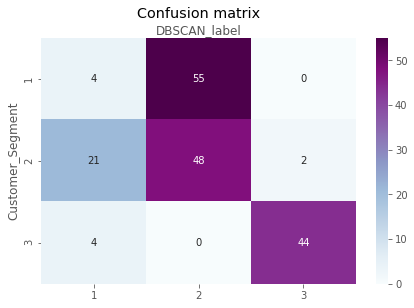

In [394]:
cm = confusion_matrix(df_dbscan['Customer_Segment'],df_dbscan['DBSCAN_label'])
class_names=[1,2,3] # name  of classes
fig, ax = plt.subplots()

# create heatmap
sns.heatmap(pd.DataFrame(cm, index=class_names,columns=class_names), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Customer_Segment')
plt.xlabel('DBSCAN_label')
plt.show()


- DBSCAN의 결과를 보니, 라벨 2값에 편향된 분포를 보이고 있다.
- eps, min_samples 등의 하이퍼파라미터 튜닝을 보다 신경써서 해야할 것같다.

# *Hierarchical clustering
실습에서 사용한 iris 데이터에서 linkage 를 달리하여 dendrogram 을 그려보세요
https://bcho.tistory.com/1204

http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/tutorials/xaghtmlnode53.html

In [395]:
from sklearn import datasets
iris = datasets.load_iris()

labels = pd.DataFrame(iris.target)
labels.columns=['labels']
data = pd.DataFrame(iris.data)
data.columns=['Sepal length','Sepal width','Petal length','Petal width']
data = pd.concat([data,labels],axis=1)

data.head()

,Sepal length,Sepal width,Petal length,Petal width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [399]:
from scipy.cluster.hierarchy import linkage, dendrogram

def linkage_tuning(method):
    mergings = linkage(data,method=method) #method =linkage설정하는것

    # Plot the dendrogram
    plt.figure(figsize=(40,20))
    dendrogram(mergings,
               labels = labels.values,
               leaf_rotation=90,
               leaf_font_size=20)
    plt.show()

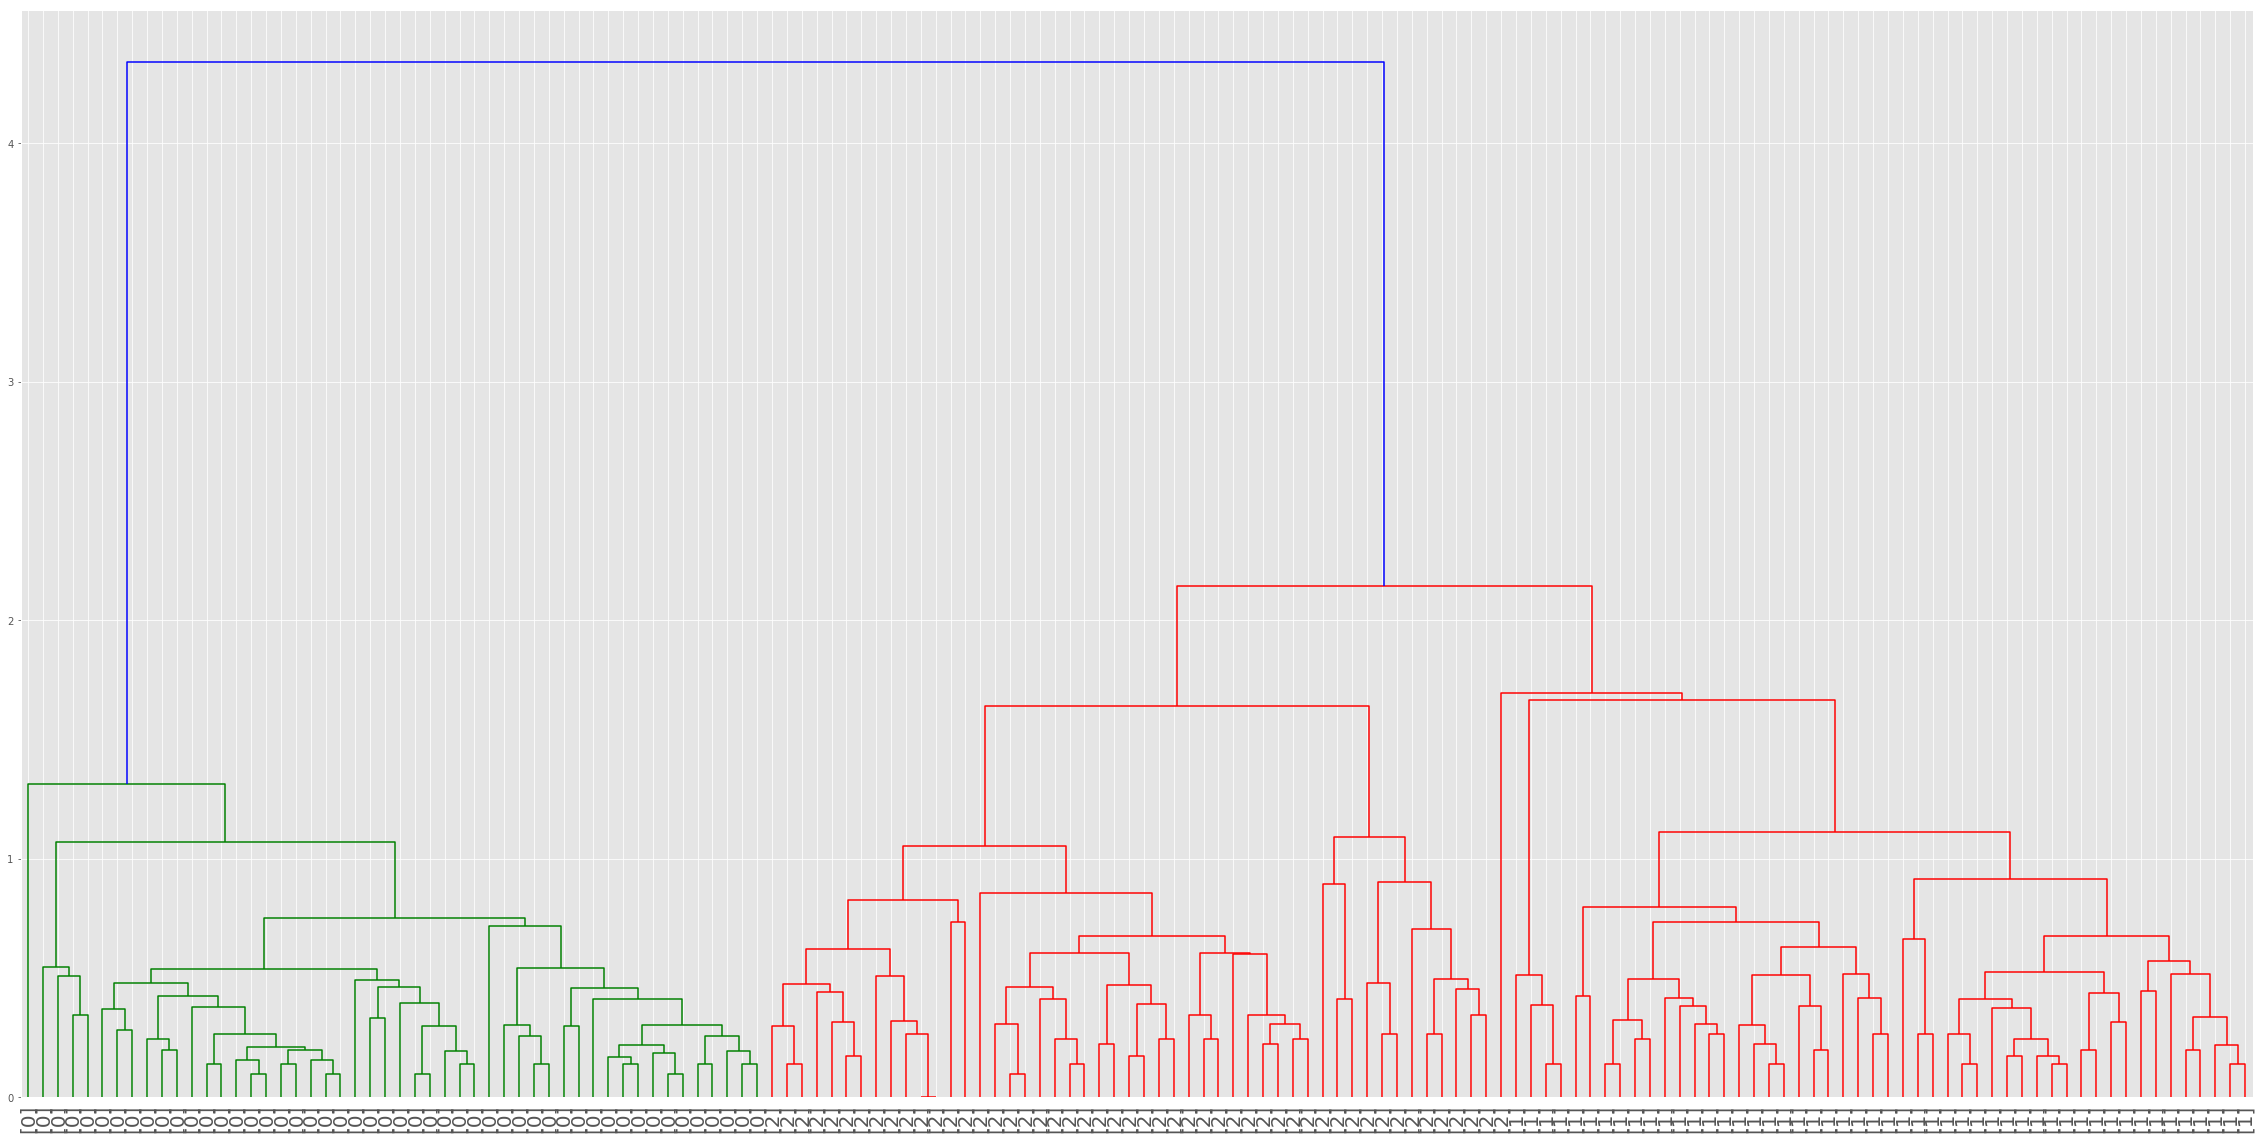

In [400]:
#average linkage 방식은 각 클러스터내의 각 점에서 다른 클러스터내의 모든 점사이의 거리에 대한 평균을 사용하는 방식
linkage_tuning('average')

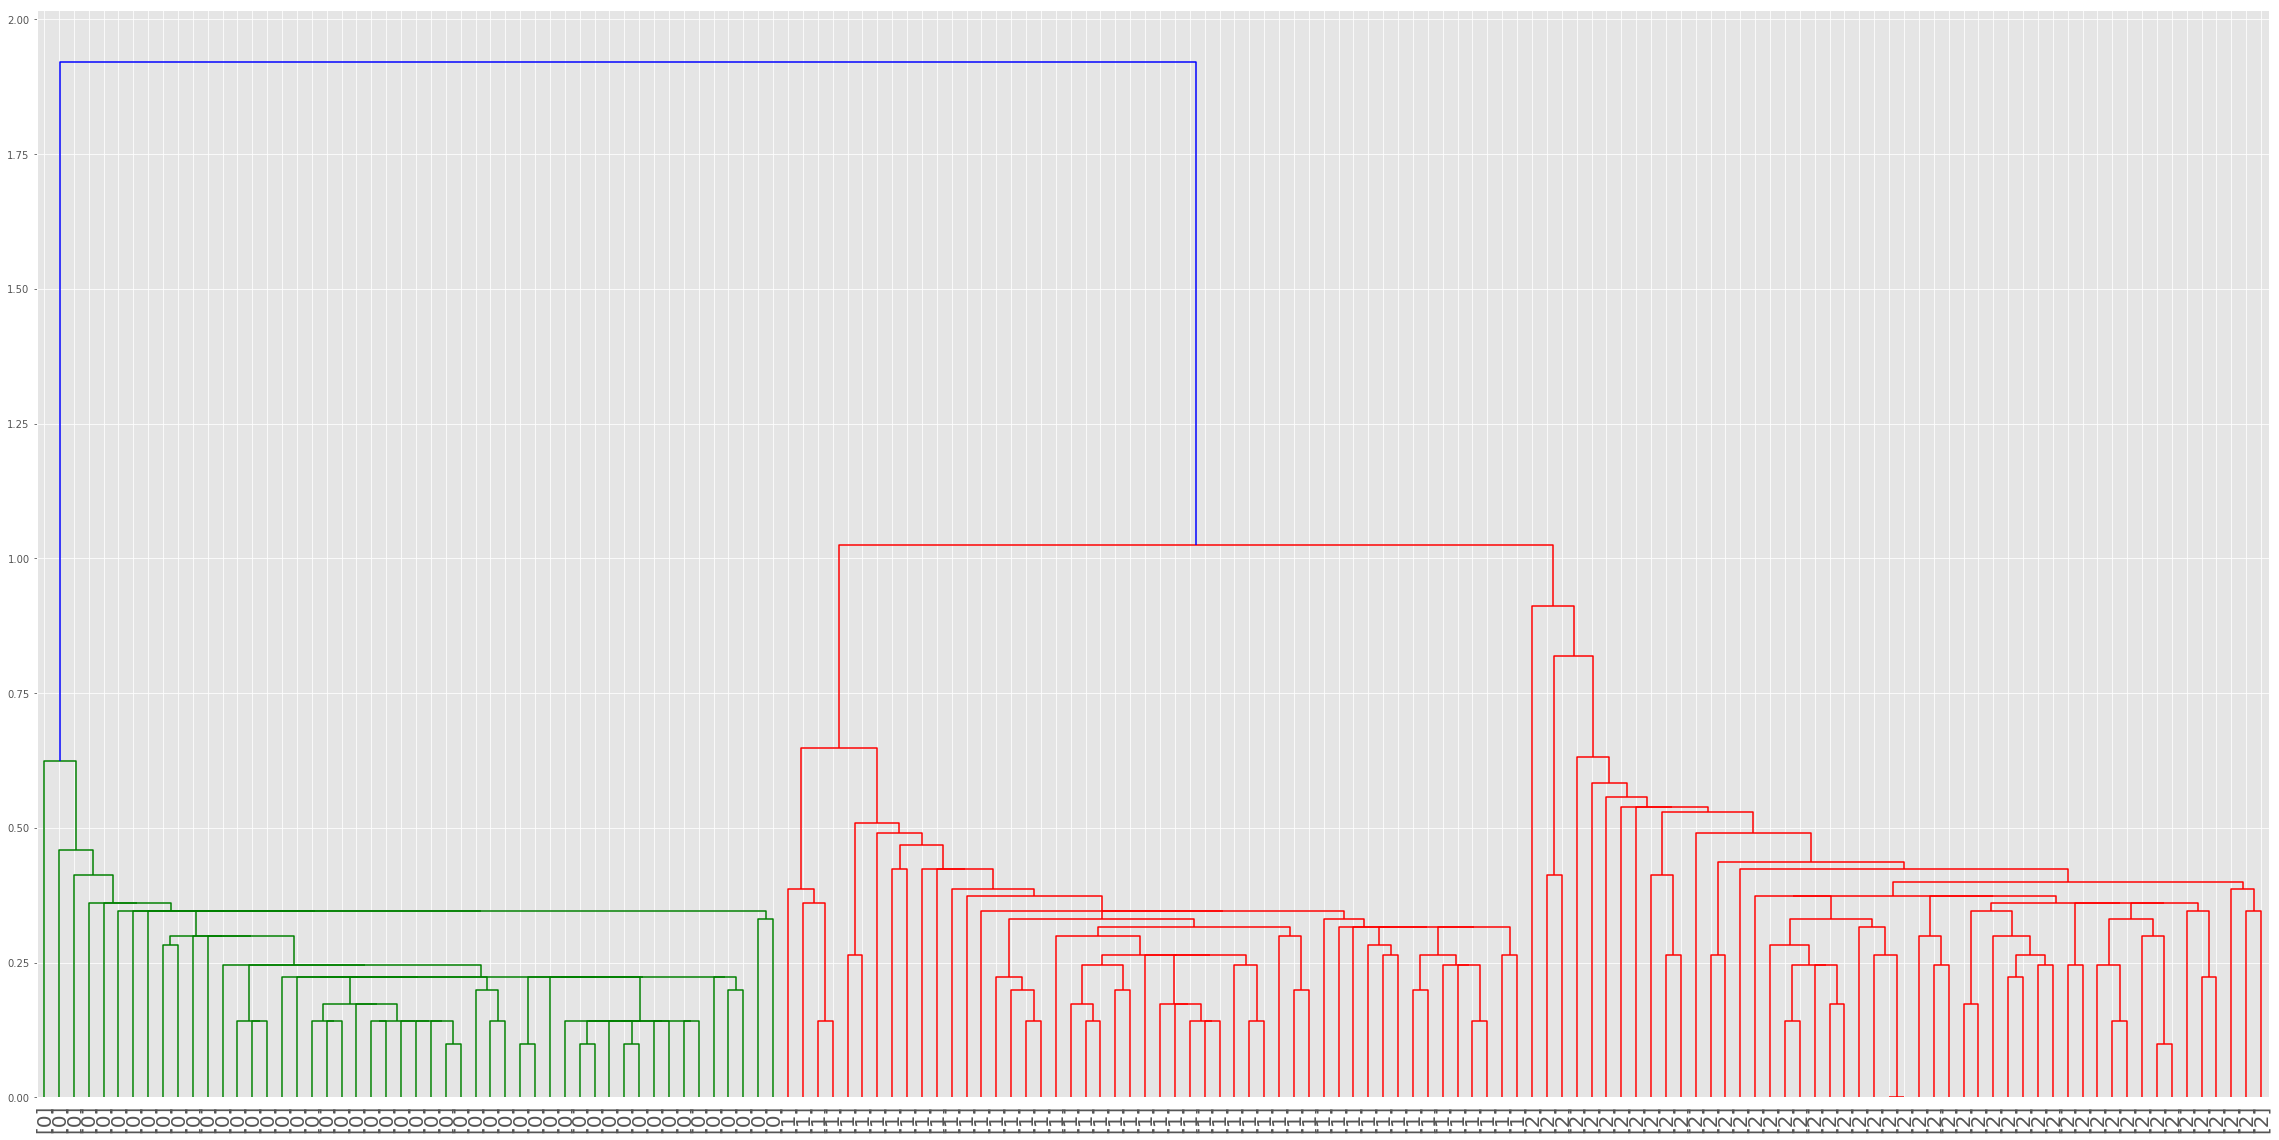

In [401]:
#single linkage 방식은 두 클러스터에서 가장 가까운 거리를 사용하는 방식
linkage_tuning('single')
#긴 시가 모양의 군집이 보인다
#가까운 거리의 애들끼리 군집이 만들어져서 긴 시가모양을 보이는 듯

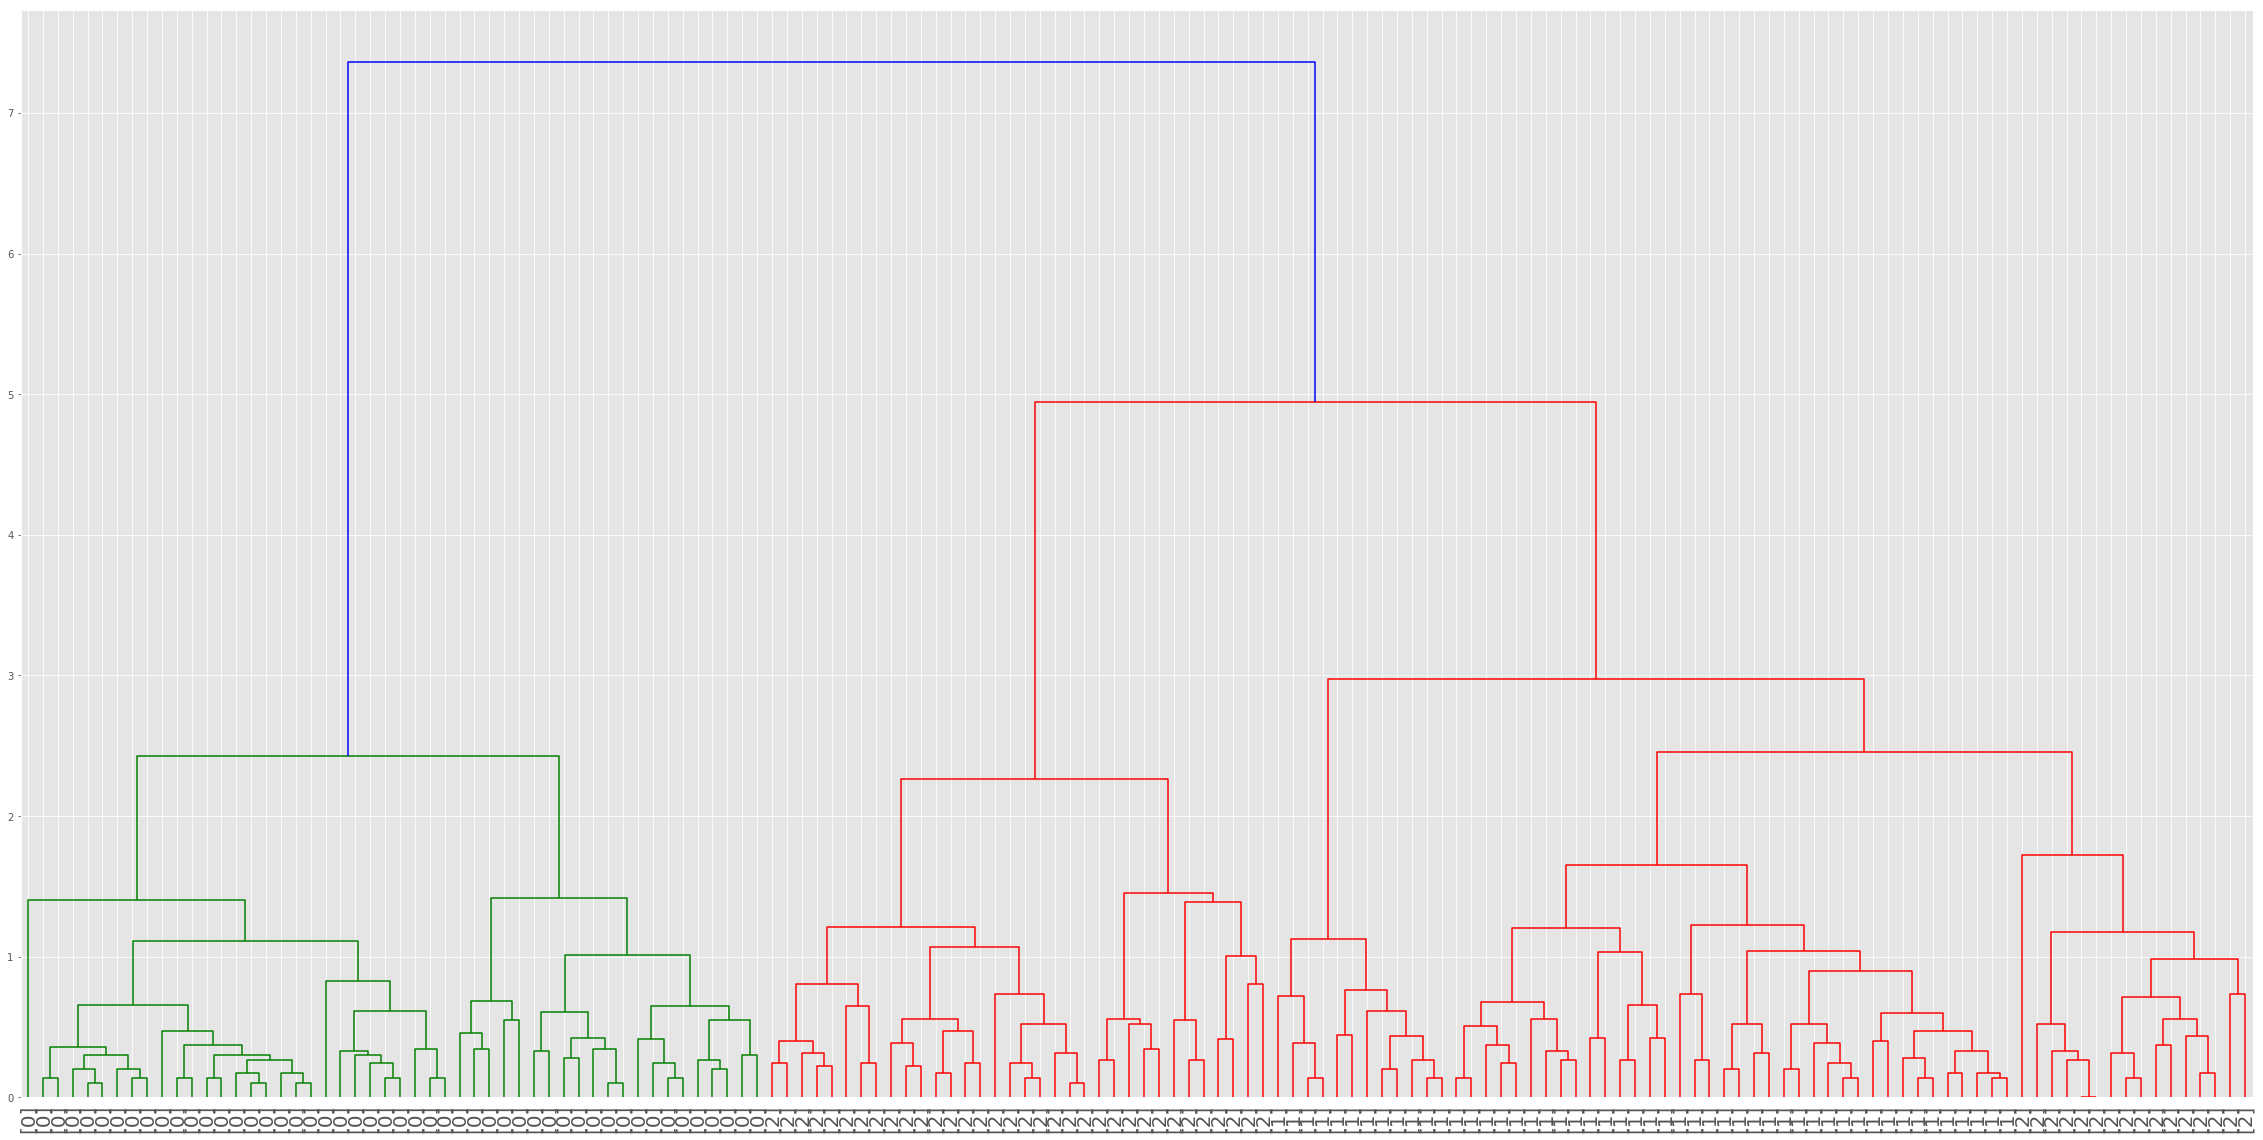

In [402]:
#complete linkage 방식은 두 클러스터상에서 가장 먼 거리를 이용해서 측정하는 방식
linkage_tuning('complete')
#이상치에 민감한 method
#두 클러스터 상에서 '가장 먼 거리'를 이용하므로, 당연히 이상치에 민감할 것으로 예상된다

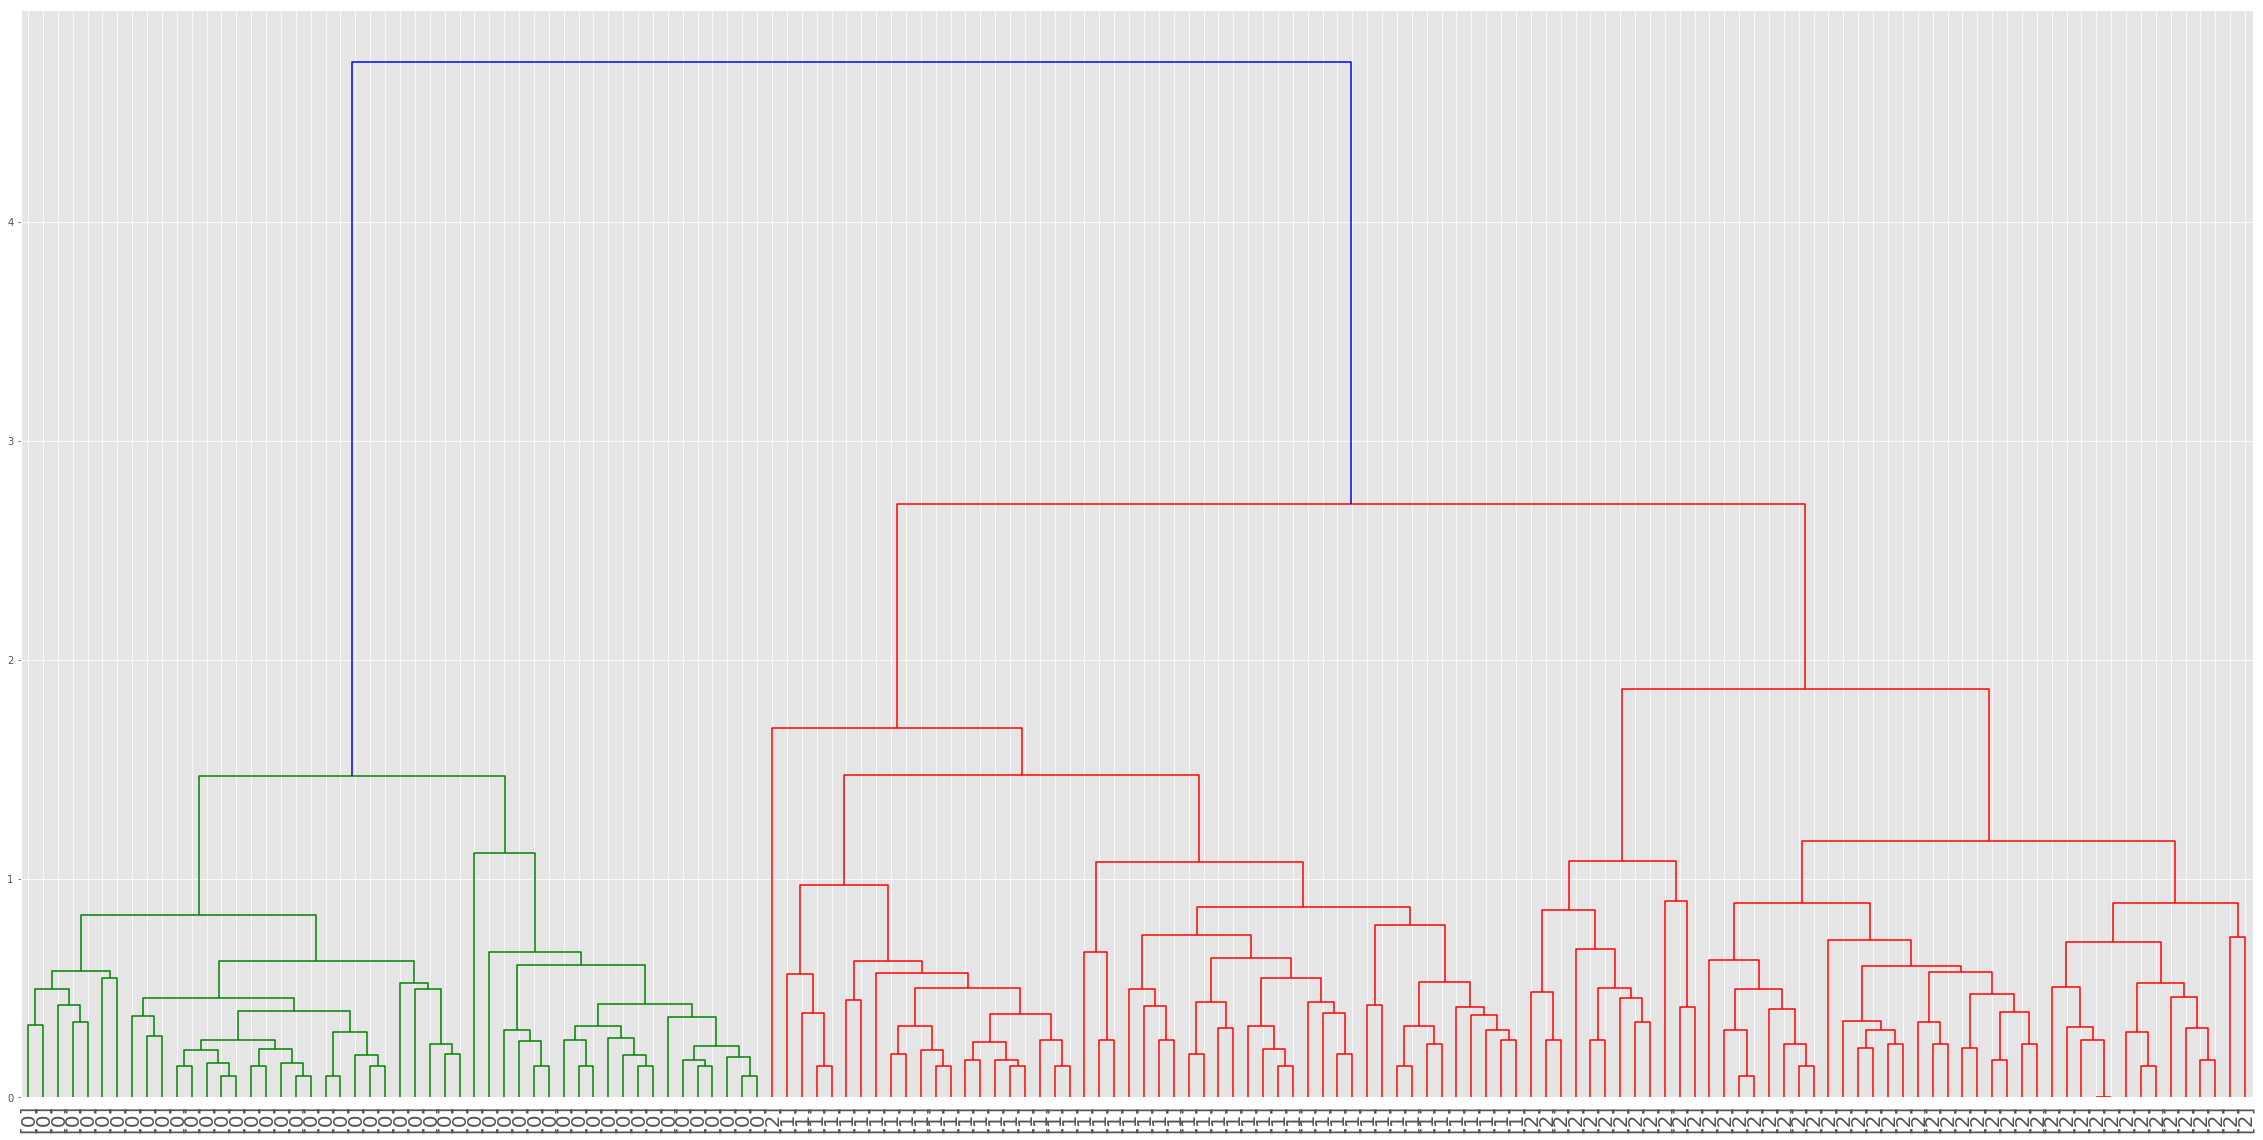

In [403]:
linkage_tuning('weighted')

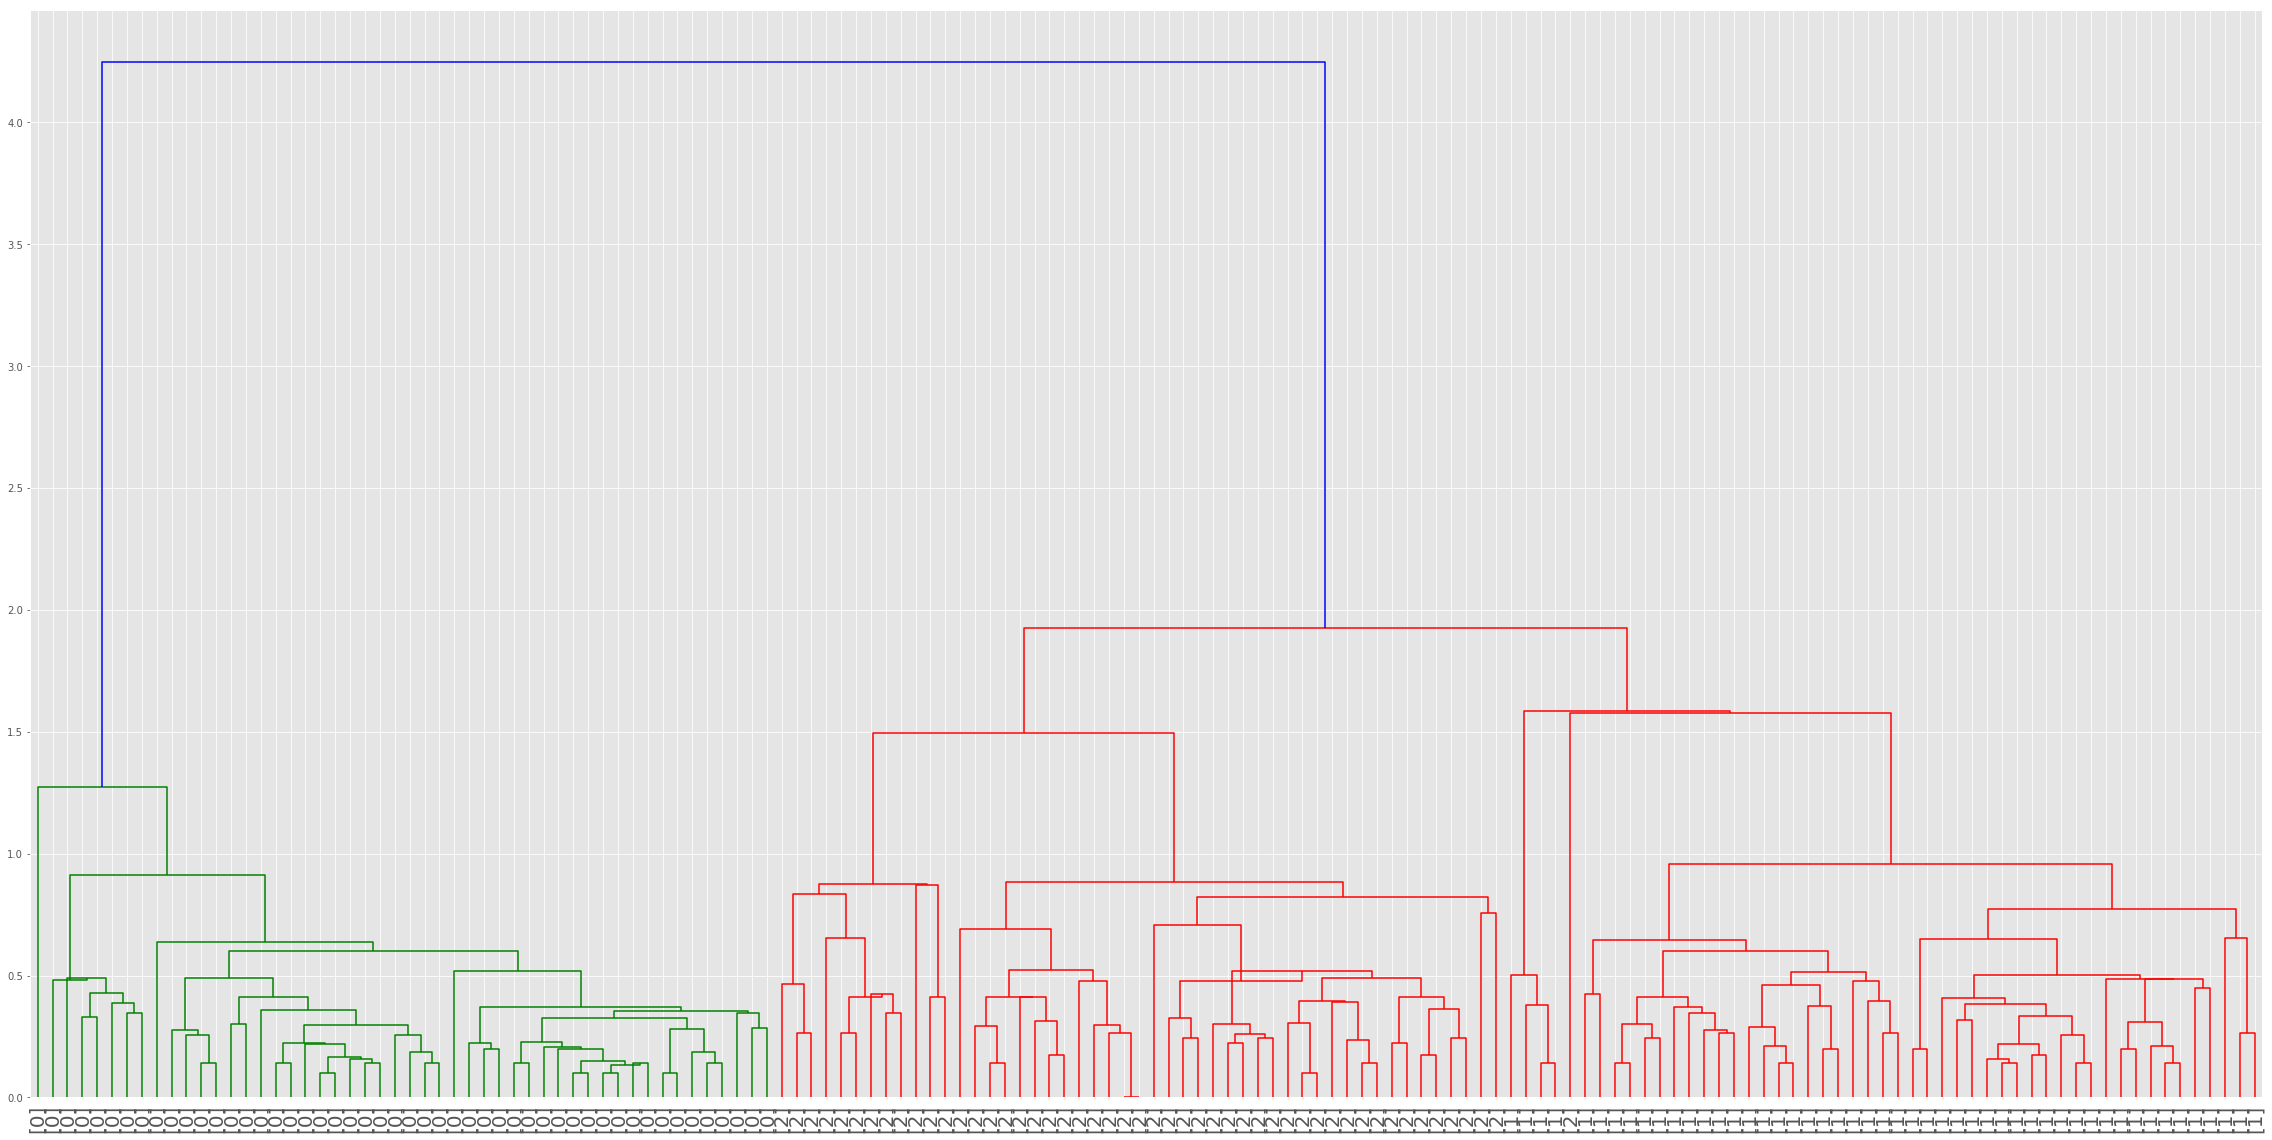

In [404]:
linkage_tuning('centroid')
#groups once formed are represented by their mean values for each variables (mean vector), 
#and inter-group distance is defined in terms of distance between two such mean vectors. The use of the mean strictly implies that the variables are on an interval scale.